# Imports and define variables

In [3]:
# try:
#   # This command only in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass

import os
import re
import pickle
from collections import Counter
import zipfile

import requests
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
### ImageDataGenerator is deprecated; instead, use tf.keras.utils.image_dataset_from_directory
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt


In [4]:
try:
    print(tf.config.list_physical_devices('GPU'))
    print(tf.test.is_built_with_cuda())

    sys_details = tf.sysconfig.get_build_info()
    cuda_version = sys_details["cuda_version"]
    print(cuda_version)

    cudnn_version = sys_details["cudnn_version"]
    print(cudnn_version)
except Exception as e:
    print(e)

[]
True
11.8
8


In [5]:
DIR_DATA = 'data'
DIR_MODELS = 'data/models'
if not os.path.exists(DIR_MODELS):
    os.makedirs(DIR_MODELS)




In [6]:
MODEL_NAME = "M1"

BATCH_SIZE = 1
EPOCHS = 50
IMG_HEIGHT = 300
IMG_WIDTH = 300


# Get data

In [152]:
# Get project files
answer = input("Download and unzip the files?")
if answer.strip().lower() == 'yes':
    # !wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
    URL = 'https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip'
    filename = os.path.basename(URL)
    r = requests.get(URL)
    with open(filename, 'wb') as f:
        f.write(r.content)
    ###
    # !unzip cats_and_dogs.zip
    with zipfile.ZipFile(filename, 'r') as zip:
        zip.extractall()
    print('[INFO] Downloaded and unzipped')
else:
    print('[INFO] Skipped.')


Download and unzip the files?no
[INFO] Skipped.


In [153]:
### cats_and_dogs/test/cats:

test_cats = ['10.jpg', '11.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '19.jpg', '20.jpg', '22.jpg', '25.jpg', '28.jpg', '29.jpg', '34.jpg',
             '35.jpg', '36.jpg', '37.jpg', '38.jpg', '40.jpg', '45.jpg', '47.jpg', '5.jpg', '50.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']

### cats_and_dogs/test/dogs:
test_dogs = ['1.jpg', '12.jpg', '17.jpg', '18.jpg', '2.jpg', '21.jpg', '23.jpg', '24.jpg', '26.jpg', '27.jpg', '3.jpg', '30.jpg',
             '31.jpg', '32.jpg', '33.jpg', '39.jpg', '4.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '46.jpg', '48.jpg', '49.jpg']

def create_dir(path):
    try:
        os.makedirs(path)
    except FileExistsError:
        print(f'[INFO] Directory {path} already exists, not doing anything')

for i in ['cats_and_dogs/test/dogs', 'cats_and_dogs/test/cats']:
    create_dir(i)

def move_files(from_dir, to_dir, files_to_move):
        for i in files_to_move:
            if i in os.listdir(to_dir):

                print(f"[INFO] {i} already present in destination directory")
            else:
                os.rename(f"{from_dir}/{i}", f"{to_dir}/{i}")


move_files('cats_and_dogs/test', 'cats_and_dogs/test/cats', test_cats)
move_files('cats_and_dogs/test', 'cats_and_dogs/test/dogs', test_dogs)


len(os.listdir('cats_and_dogs/test/cats'))
len(os.listdir('cats_and_dogs/test/dogs'))

[INFO] Directory cats_and_dogs/test/dogs already exists, not doing anything
[INFO] Directory cats_and_dogs/test/cats already exists, not doing anything
[INFO] 10.jpg already present in destination directory
[INFO] 11.jpg already present in destination directory
[INFO] 13.jpg already present in destination directory
[INFO] 14.jpg already present in destination directory
[INFO] 15.jpg already present in destination directory
[INFO] 16.jpg already present in destination directory
[INFO] 19.jpg already present in destination directory
[INFO] 20.jpg already present in destination directory
[INFO] 22.jpg already present in destination directory
[INFO] 25.jpg already present in destination directory
[INFO] 28.jpg already present in destination directory
[INFO] 29.jpg already present in destination directory
[INFO] 34.jpg already present in destination directory
[INFO] 35.jpg already present in destination directory
[INFO] 36.jpg already present in destination directory
[INFO] 37.jpg already p

24

In [154]:
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
# total_test = len(os.listdir(test_dir))
total_test = sum([len(files) for r, d, files in os.walk(test_dir)])

def print_count(label, count):
    print(f"[INFO] {label}: {count}")

print_count('train', total_train)
print_count('val', total_val)
print_count('test', total_test)

# Variables for pre-processing and training.
# batch_size = 128
# epochs = 15


[INFO] train: 2001
[INFO] val: 1001
[INFO] test: 51


In [155]:
os.listdir('cats_and_dogs/test')

['.DS_Store', 'cats', 'dogs']

In [156]:
# 3

train_ds = image_dataset_from_directory(
    'cats_and_dogs/train',
    batch_size=BATCH_SIZE
)
class_names = train_ds.class_names
print(train_ds.class_names)

validation_ds = image_dataset_from_directory(
    'cats_and_dogs/validation',
    batch_size=BATCH_SIZE
)

test_ds = image_dataset_from_directory(
    'cats_and_dogs/test',
    batch_size=BATCH_SIZE
)


Found 2000 files belonging to 2 classes.
['cats', 'dogs']
Found 1000 files belonging to 2 classes.
Found 50 files belonging to 2 classes.


{{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/


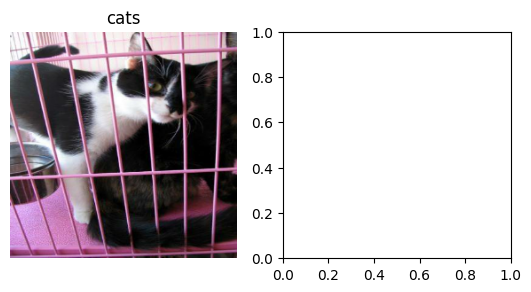

In [157]:
plt.figure(figsize=(10, 10))
try:
    for images, labels in train_ds.take(1):
        for i in range(3): # 2 images in batch
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
except Exception as e:
    print(e)

In [158]:
for images1, labels1 in train_ds.take(1):
  image1 = images[0]


 - Batch:  (1, 256, 256, 3)
(256, 3)
[[246 245 249]
 [242 241 244]
 [179 178 183]
 [236 234 239]
 [252 247 253]
 [250 245 251]
 [253 248 254]
 [249 243 249]
 [202 192 200]
 [241 231 239]
 [254 250 254]
 [249 248 254]
 [249 248 254]
 [248 246 247]
 [214 207 206]
 [251 237 237]
 [255 240 243]
 [236 205 216]
 [163 122 145]
 [128  78 113]
 [177 121 165]
 [252 223 251]
 [255 248 253]
 [248 247 243]
 [225 223 219]
 [245 240 237]
 [254 250 248]
 [254 245 244]
 [235 217 217]
 [194 171 173]
 [187 161 164]
 [225 195 199]
 [254 226 230]
 [193 155 157]
 [179 143 143]
 [213 179 179]
 [254 224 225]
 [184 154 156]
 [173 142 147]
 [243 213 220]
 [215 184 193]
 [183 145 158]
 [226 186 200]
 [252 219 230]
 [192 160 168]
 [206 175 181]
 [244 223 229]
 [205 176 181]
 [218 189 194]
 [252 224 229]
 [220 194 198]
 [242 217 221]
 [250 226 230]
 [227 204 207]
 [248 234 237]
 [227 223 230]
 [239 219 231]
 [254 228 244]
 [251 220 236]
 [255 234 248]
 [244 214 230]
 [177 128 150]
 [149  87 114]
 [193 144 166]
 [2

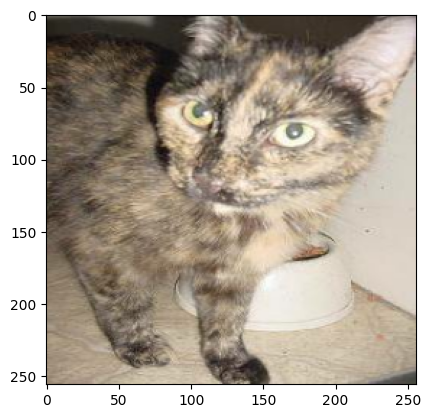

In [159]:
print(' - Batch: ', images1.shape)
img = image1[0].numpy().astype("uint8")
print(img.shape)
print(img)
plt.imshow(images1[0].numpy().astype("uint8"))


(1, 256, 256, 3)


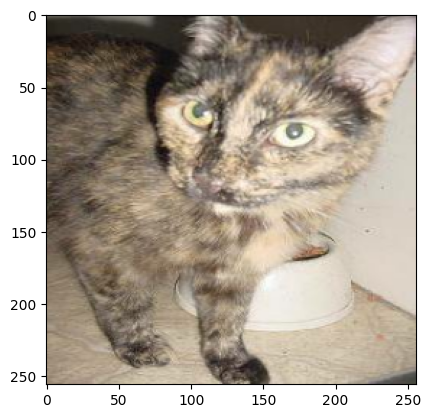

In [160]:
img1, lbl1 = next(iter(train_ds))

print(img1.shape)
plt.imshow(img1[0].numpy().astype("uint8"))
# plt.title(lbl1[0])


# Model

(1, 256, 256, 3)
(1, 300, 300, 3)
(1, 300, 300, 3)
(1, 300, 300, 3)


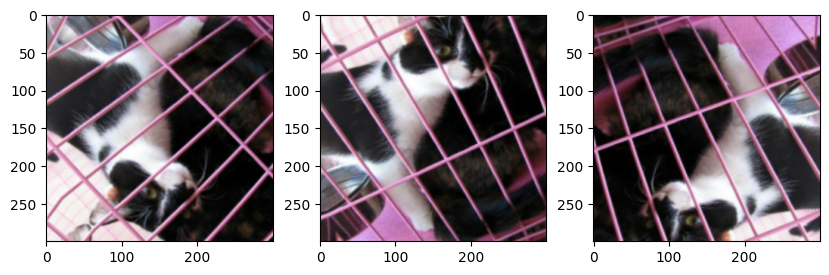

In [161]:
"""
Not all augmentation layers work if run with GPU.
Error - JIT compilation - who knows what that is

Google colab - works with CPU and GPU
""";

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomCrop(220, 220),
    # layers.RandomZoom((0.1,0.2), (0.1,0.2))
    tf.keras.layers.Resizing(IMG_HEIGHT, IMG_WIDTH)
])

image1_4d = tf.expand_dims(image1, 0)
print(image1_4d.shape)

plt.figure(figsize = (10,10))
for i in range(3):
    image1_aug = data_augmentation(image1_4d);
    print(image1_aug.shape)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image1_aug[0].numpy().astype("uint8"))
    # plt.axis("off")

In [162]:
# 5
# train_image_generator = None

### Standardise the data
# [0, 255] -> [0, 1]

num_classes = 2


model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])


In [163]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)


In [164]:
# train_ds1 = train_ds.batch(8)
# validation_ds1 = validation_ds.batch(8)

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs = EPOCHS
)


Epoch 1/50
2000/2000 [==============================] - 28s 13ms/step - loss: 0.7158 - accuracy: 0.4955 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/50
2000/2000 [==============================] - 25s 12ms/step - loss: 0.7139 - accuracy: 0.4945 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/50
2000/2000 [==============================] - 29s 15ms/step - loss: 0.6935 - accuracy: 0.4885 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/50
2000/2000 [==============================] - 25s 12ms/step - loss: 0.6950 - accuracy: 0.4915 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/50
2000/2000 [==============================] - 24s 12ms/step - loss: 0.6951 - accuracy: 0.4905 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/50
2000/2000 [==============================] - 29s 14ms/step - loss: 0.6936 - accuracy: 0.4930 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/50
2000/2000 [==============================] - 29s 15ms/step - loss: 0.6936 - accuracy: 0.4900 - val_loss: 0.6932 -

In [165]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 sequential_12 (Sequential)  (None, 300, 300, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 149, 149, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 73, 73, 32)        0         
 ng2D)                                               

In [166]:
history

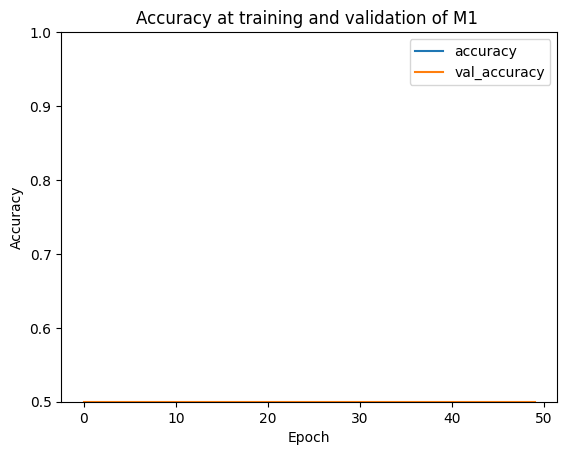

In [167]:

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
# plt.legend(loc='lower right')
plt.legend()
plt.title(f"Accuracy at training and validation of {MODEL_NAME} ")
plt.savefig(f"{DIR_MODELS}/{MODEL_NAME}_train.jpg")


In [168]:
# Save the entire model as a `.keras` zip archive.
MODEL_FULL_PATH = f'{DIR_MODELS}/{MODEL_NAME}.keras'
model.save(MODEL_FULL_PATH)

In [8]:
# loaded_model = tf.keras.models.load_model(MODEL_FULL_PATH)
# loaded_model = tf.keras.models.load_model('data/models/M4.keras')
loaded_model = tf.keras.models.load_model('M4.keras')
loaded_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 sequential_6 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 149, 149, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 73, 73, 32)        0         
 ng2D)                                                

# Test

In [206]:
# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
test_loss, test_acc = loaded_model.evaluate(test_ds, verbose=2)
print(f"[INFO] Test accuracy: {test_acc:.3f}")


50/50 - 1s - loss: 0.5002 - accuracy: 0.7400 - 634ms/epoch - 13ms/step
[INFO] Test accuracy: 0.740


In [13]:
# !pip install Pillow

img_proc = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Resizing(256, 256)
])


1/1 [==============================] - 0s 77ms/step


Text(0.5, 1.0, 'Prediction: cat')

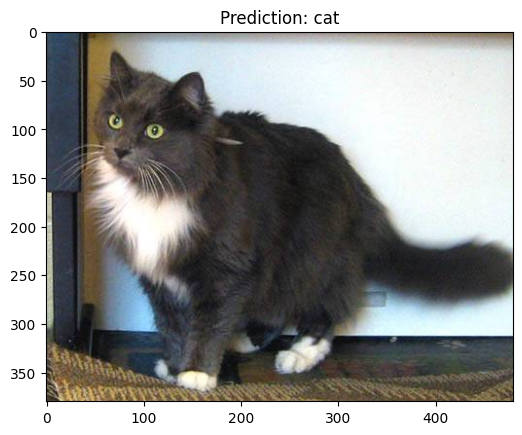

In [33]:
image_path = '9.jpg'
# image_path = 'cats_and_dogs/test/dogs/18.jpg'
# image_path = 'cats_and_dogs/test/cats/.jpg'

import PIL
from PIL import Image

image = tf.keras.utils.load_img(image_path)
input_arr = tf.keras.utils.img_to_array(image)

input_arr = np.array([input_arr])  # Convert single image to a batch.
input_arr_proc = img_proc(input_arr)
predictions = loaded_model.predict(input_arr_proc).argmax(axis=1)[0]

plt.imshow(image)
# plt.title(f'Prediction: {train_ds.class_names[predictions]}')
list1 = ['cat', 'dog']
plt.title(f'Prediction: {list1[predictions]}')



In [189]:
train_ds.class_names

['cats', 'dogs']

In [173]:
image_path = 'cats_and_dogs/train/cats/cat.0.jpg'
# image_path = 'cats_and_dogs/test/cats/5.jpg'


# image = tf.keras.utils.load_img(image_path)
image = Image.open(image_path)
# image = image.resize((250,250))
input_arr = tf.keras.utils.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.

print(input_arr.shape)

# input_arr_proc = tf.expand_dims(input_arr, axis=0)

predictions = model.predict(input_arr)
predictions